## DESAFIO

Você foi alocado(a) em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema. O uso de outras fontes de dados além do dataset é permitido (e encorajado). Você poderá encontrar em anexo um dicionário dos dados.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import pickle

## Questão 1 - Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas.

In [5]:
#Resposta Questão 1
data = pd.read_csv("teste_indicium_precificacao.csv")
#Informacoes sobre o dataset
print(data.head())
print(data.columns)
print(data.count())
print(data.shape)
print(data.isna().sum())
print(data.describe())
print(data['price'].median())
print(data['price'].mean())
print(data['price'].max())
print(data['price'].min())
print(data['bairro_group'].value_counts())
print(data.info())


#dados faltantes de strings
data['nome'] = data['nome'].fillna('Sem informacao')
data['bairro_group'] = data['bairro_group'].fillna('Sem informacao do grupo do bairro')
data['bairro'] = data['bairro'].fillna('Sem informacao do bairro')
data['room_type'] = data['room_type'].fillna('Sem informacao do tipo de quarto')
data['host_name'] = data['host_name'].fillna('Sem informaccoes do anfitriao')

#dados faltantes de numericos
data['numero_de_reviews'] = data['numero_de_reviews'].fillna(0)
data['reviews_por_mes'] = data['reviews_por_mes'].fillna(0)
data['disponibilidade_365'] = data['disponibilidade_365'].fillna(0)

#valores com datas
data['ultima_review'] = data['ultima_review'].fillna('1800-06-07')

     id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150   

## Questão 2: Letra A - Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra? 

Resposta questão 2 letra A: Bem, ao analisarmos algumas questões como a quantidade de reviews, já que quanto mais reviews positivas um bairro tiver, mais chances de ser recomendado para outras pessoas, outras informações como preços e disponibilidades de dias durante o ano, além do preço dos quartos, podemos ver por meio das análises geradas em gráficos e textos que poderia ser qualquer um dos bairros mostrados abaixo.

melhores bairros com maiores precos médios: 
                    price
bairro_group             
Bronx           87.496792
Queens          99.517649
Staten Island  114.812332
Brooklyn       124.381983
Manhattan      196.875814
Bairros com mais reviews: 
 bairro
Bedford-Stuyvesant    110352
Williamsburg           85427
Harlem                 75962
Bushwick               52514
Hell's Kitchen         50227
Name: numero_de_reviews, dtype: int64
Bairros com maior disponibilidade de dias: 
 bairro
Fort Wadsworth    365.000000
Co-op City        364.000000
Willowbrook       351.000000
Eastchester       333.461538
Richmondtown      300.000000
Name: disponibilidade_365, dtype: float64


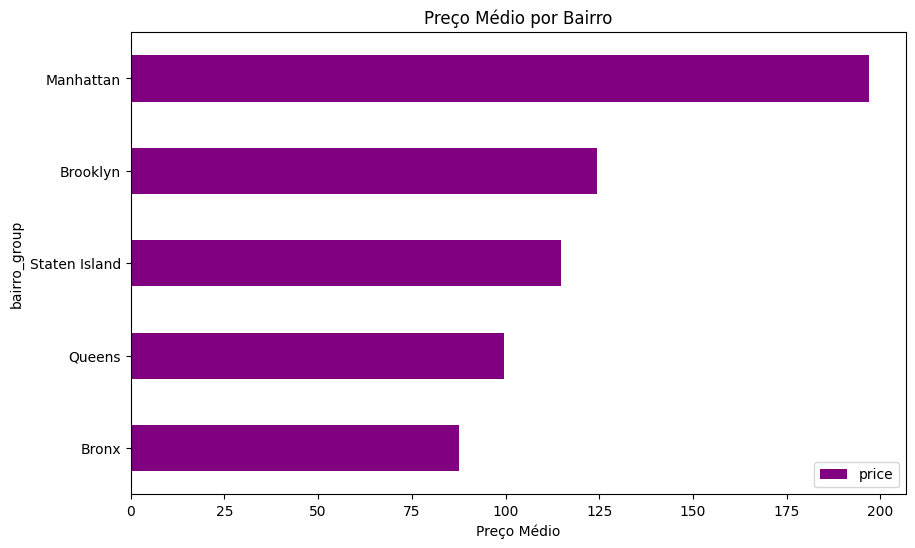

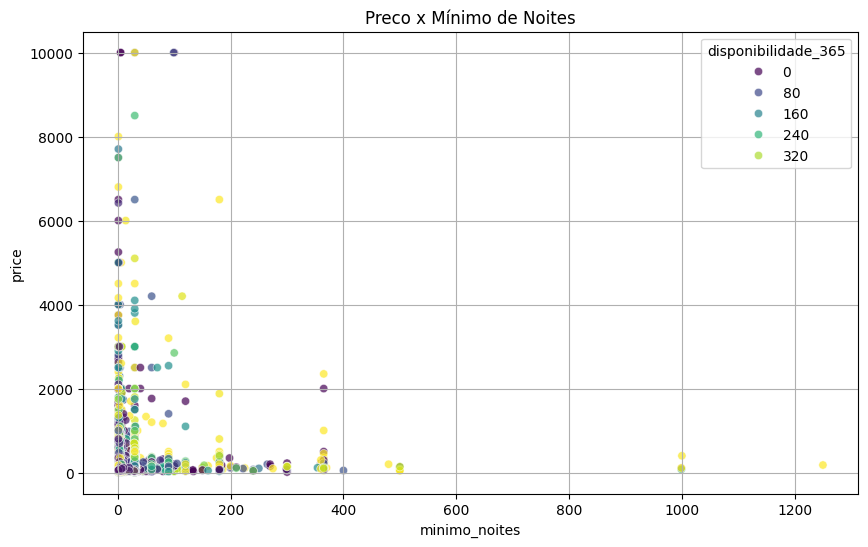

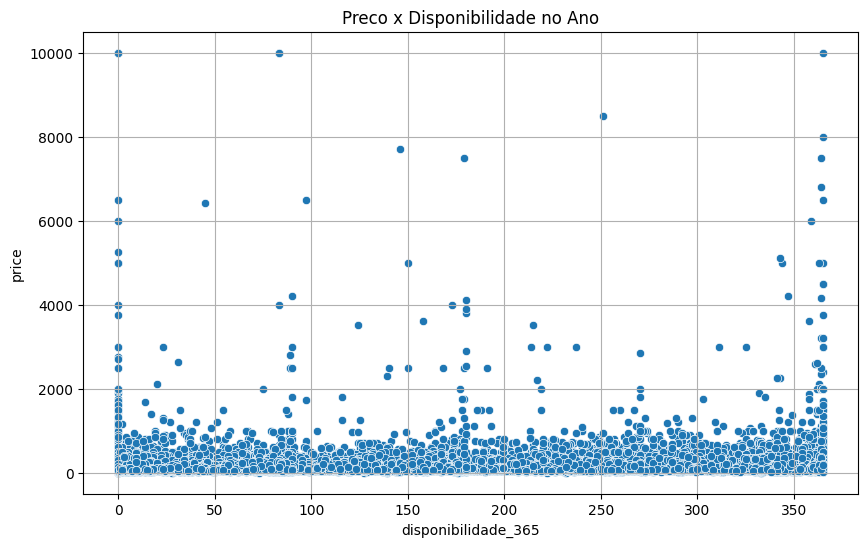

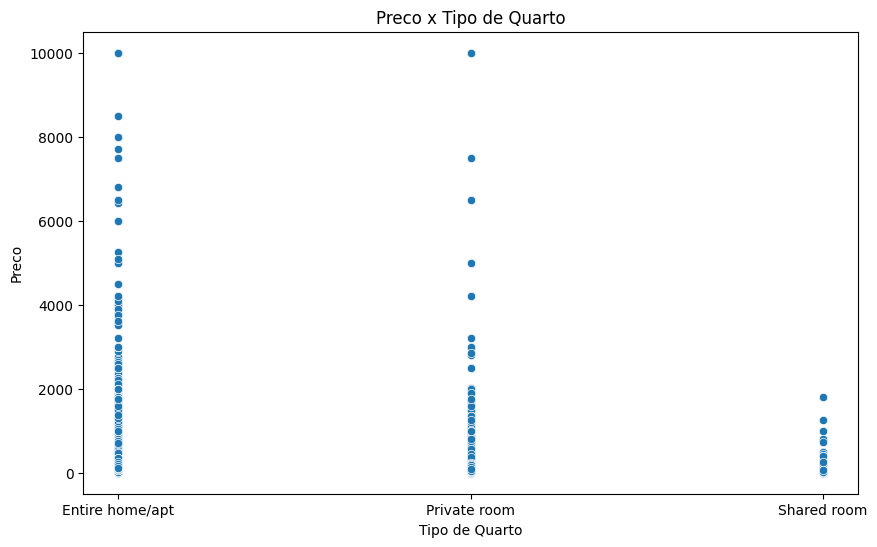

In [6]:
#A compra poderia ser realizada em qualquer um dos resultados disponíveis abaixo 
precoGrupo = data.groupby('bairro_group')[['price']].mean().sort_values('price')
reviewBairros = data.groupby('bairro')['numero_de_reviews'].sum().sort_values(ascending=False)
disponibilidadeBairros = data.groupby('bairro')['disponibilidade_365'].mean().sort_values(ascending=False)

print("melhores bairros com maiores precos médios: \n{}" .format(precoGrupo.head(5)))
print("Bairros com mais reviews: \n {}" .format(reviewBairros.head(5)))
print("Bairros com maior disponibilidade de dias: \n {}" .format(disponibilidadeBairros.head(5)))

precoGrupo.plot(kind='barh', figsize=(10, 6), color='purple')
plt.title('Preço Médio por Bairro')
plt.xlabel('Preço Médio')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='minimo_noites', y='price', data=data, hue = 'disponibilidade_365', alpha = 0.7, palette ='viridis')
plt.title('Preco x Mínimo de Noites')
plt.grid(True) 
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='disponibilidade_365', y='price', data=data)
plt.title('Preco x Disponibilidade no Ano')
plt.grid(True) 
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='room_type', y='price', data=data) 
plt.title('Preco x Tipo de Quarto')
plt.ylabel('Preco') 
plt.xlabel('Tipo de Quarto')
plt.show()

## Questão 2: Letra B - O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Resposta Questão 2: Letra B - Ao criarmos um gráfico de correlação entre as variáveis, podemos ver que temos valores muito baixos como 0,043 e 0,082. Por esses valores serem tão baixos, a interferência deles no preço final não será tão grande a ponto de ser relevante.

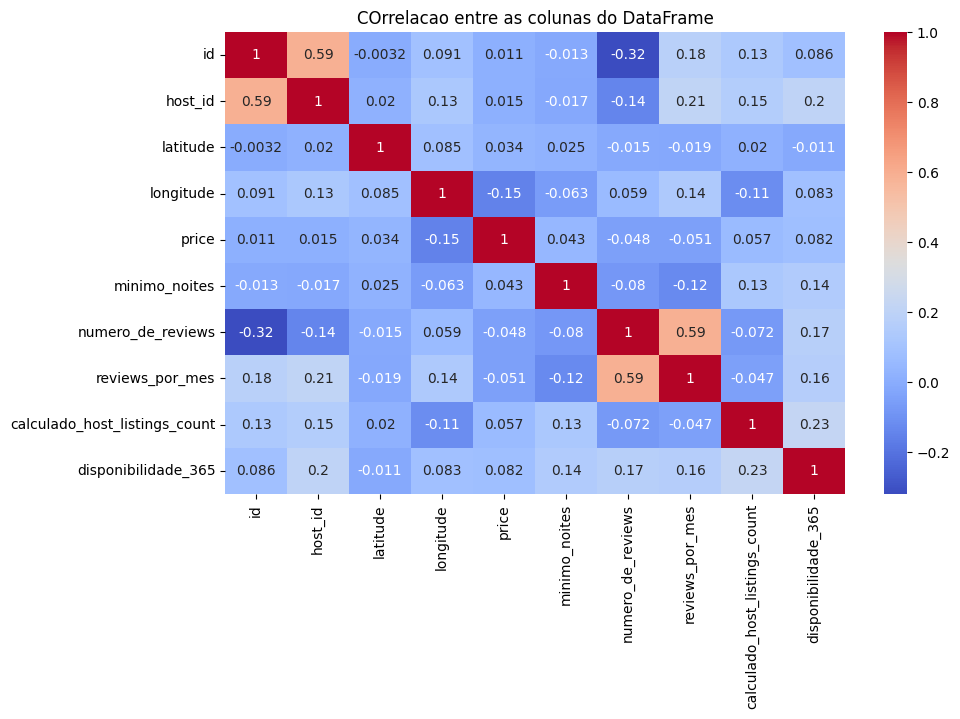

In [7]:

graficoCorrela = data.select_dtypes(include=['int64' , 'float64']).corr()
plt.figure(figsize = (10,6))
sns.heatmap(graficoCorrela, cmap = 'coolwarm', annot = True)
plt.title('COrrelacao entre as colunas do DataFrame')
plt.show()

## Questão 2: Letra C - Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Resposta Questão 2: Letra C - Ao observarmos o conjunto de áreas de todos os bairros filtrados pelo preço, percebemos que alguns nomes como Hills, Bay, East, Island, Park, Heights, Beach ou Wood se repetem com certa frequência na lista de bairros, porém, estão muito separados uns dos outros. Mas ao reduzirmos para um grupo de 10 áreas por bairros, ficamos somente com algumas palavras que se repetem em pelo menos duas áreas e são elas: Bay, Island, Hills, Park, East e West. Isso pode ser considerado um padrão nos lugares de alto valor.

In [8]:
#Questão 2 Letra C
divisaoBairro = data.sort_values(by='price', ascending=False).groupby('bairro_group')['bairro'].unique().to_dict()
for i, j in divisaoBairro.items():
    print("Grupo dos bairros: {}" .format(i))
    print("Bairros: {}\n" .format(j))

Grupo dos bairros: Bronx
Bairros: ['Riverdale' 'City Island' 'Longwood' 'Westchester Square'
 'Williamsbridge' 'Mott Haven' 'Eastchester' 'Unionport' 'Pelham Gardens'
 'Allerton' 'Van Nest' 'Kingsbridge' 'Claremont Village' 'Clason Point'
 'Spuyten Duyvil' 'Throgs Neck' 'Wakefield' 'Parkchester' 'Pelham Bay'
 'Belmont' 'Concourse' 'Mount Hope' 'Morris Heights' 'Highbridge'
 'Morrisania' 'Fordham' 'Port Morris' 'Norwood' 'East Morrisania'
 'Morris Park' 'University Heights' 'West Farms' 'Concourse Village'
 'Schuylerville' 'Melrose' 'Hunts Point' 'Tremont' 'North Riverdale'
 'Mount Eden' 'Edenwald' 'Fieldston' 'Castle Hill' 'Olinville' 'Soundview'
 'Baychester' 'Bronxdale' 'Woodlawn' 'Co-op City']

Grupo dos bairros: Brooklyn
Bairros: ['Greenpoint' 'Clinton Hill' 'East Flatbush' 'Bedford-Stuyvesant'
 'Cypress Hills' 'Williamsburg' 'Bay Ridge' 'Prospect Heights'
 'Brighton Beach' 'Park Slope' 'Prospect-Lefferts Gardens' 'Crown Heights'
 'Sunset Park' 'Sheepshead Bay' 'Bushwick' 'Cobble H

## Questão 3: Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Resposta Questão 3: Como "price" é uma variável contínua e estamos querendo prever um valor para ela, o problema seria de regressão.

Para a previsão do preço, utilizei o modelo da biblioteca sklearn chamado de random forest regressor. Ele utiliza um conjunto de árvores de decisão para prever os resultados a partir de subconjuntos de dados, além de ter uma boa precisão e velocidade. Então limpei os dados que não seriam utilizados na análise, também transformei algumas das variáveis em dummies, já que o modelo poderia não conseguir lidar com os dados categóricos. Utilizei um drop para criar um novo dataframe sem as informações anteriores e dividi os dados para ter 20% deles sendo usados para o teste e também declarei um valor de 100 árvores de decisão. Com isso, consegui prever um valor para o valor que pagariam para aquele apartamento.

Acredito que os melhores modelos para essa análise seriam os modelos de regressão linear, como o LinearRegression, os baseados em árvores como o random forest regressor e os baseados em ensemble como o gradient boosting regressor. O modelo que utilizei tem como vantagens a não linearidade, pouco-processamento e talvez uma fácil interpretação, porém sofre por poder sofrer de Overfitting e instabilidade. O modelo chamado LinearRegression tem como vantagens a simplicidade, eficiência e é menos propenso a overfitting, mas tem como desvantagens a linearidade, outliers e a multicolinearidade. Enquanto o gradient boosting regressor tem como vantagens a alta precisão, robustez e a flexibilidade, porém, pode sofrer por ser complexo demais para utilizar, o tempo de treinamento pode ser lento, o que pode fazer com que pessoas não tão familiarizadas com a tecnologia se compliquem.

Acredito que as melhores medidas a serem escolhidas são a de R² e a MAE, pois o R² é uma métrica importante para determinar a qualidade do ajuste do modelo aos dados, já que se trata de uma medida para calcular o quão próximo os dados estão da linha de regressão. Os valores podem variar entre 0 e 1, quanto mais próximo de 1 o valor estiver, mais confiáveis aquelas informações serão. Mas eu também poderia utilizar outras medidas como o MAE, já que eu poderia tentar minimizar os erros absolutos com isso, porém, diferente do R², quanto menor o valor do meu MAE melhor, pois isso significaria que tenho menos erros.

## Questão 4: Supondo um apartamento com as seguintes características, qual seria a sua sugestão de preço? 

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}



In [9]:
vectorizer = CountVectorizer()

X = data.drop(['price', 'id', 'nome', 'host_id', 'host_name', 'ultima_review'], axis=1)
y = data['price']

X = pd.get_dummies(X, columns=['bairro_group', 'bairro', 'room_type'], drop_first=True)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
r2 = r2_score(yTest, yPred)
print("Resultado do R**2: {}" .format(r2))
mae = mean_absolute_error(yTest, yPred)
print("REsultado do MAE em dolares: {}" .format(mae))


apartamento = {'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355}

novoData = pd.DataFrame([apartamento])
novoData = novoData.reindex(columns=X.columns, fill_value=0)
precoPrevisto = model.predict(novoData)
print("Preco previsto: {}" .format(precoPrevisto[0]))



Resultado do R**2: -0.09258935397178192
REsultado do MAE em dolares: 66.5705266387156
Preco previsto: 326.44


Como não sei a preferencia pelo uso da biblioteca pickle ou joblib, converti para o .pkl utilizando as duas

In [10]:
with open('modeloPrecificacao_pickle.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('modeloPrecificacao_pickle.pkl', 'rb') as file:
    modeloCarregadopickle = pickle.load(file)
    
joblib.dump(model, 'modeloPrecificacao_joblib.pkl')
modeloCarregadojoblib = joblib.load('modeloPrecificacao_joblib.pkl')
